# 全局分割预测

## 导入相关库和优化可视化效果

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2

def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)
    polygons = []
    color = []
    for ann in sorted_anns:
        m = ann['segmentation']
        img = np.ones((m.shape[0], m.shape[1], 3))
        color_mask = np.random.random((1, 3)).tolist()[0]
        for i in range(3):
            img[:,:,i] = color_mask[i]
        ax.imshow(np.dstack((img, m*0.35)))


## 读取数据

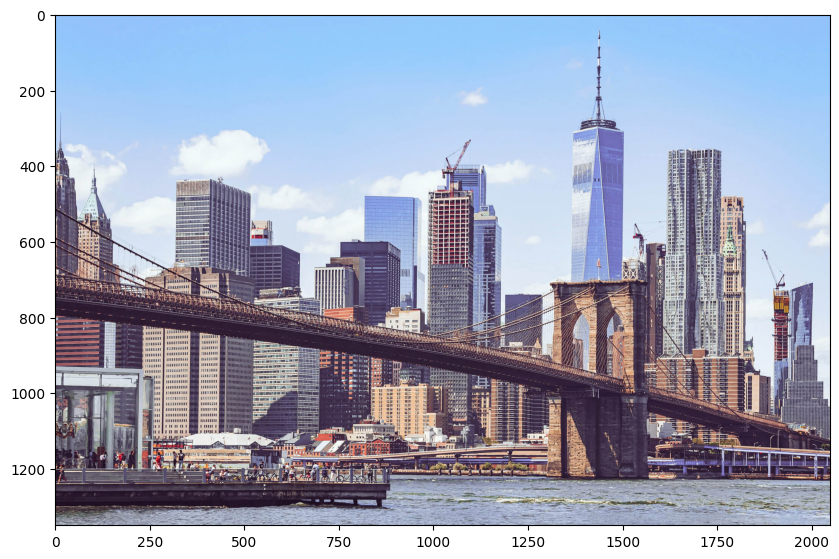

In [2]:
image = cv2.imread('./pics/GettyImages-1207911110.jpg')
# 还原原图像色彩
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10,10))
plt.imshow(image)
plt.axis('on')
plt.show()


## 加载模型

In [3]:
import sys
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

# 加载模型
sam_checkpoint = './models/sam_vit_h_4b8939.pth'
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

# 调用全局分割模型
mask_generator = SamAutomaticMaskGenerator(sam)


/home/ubuntu/桌面/20240910-SVM/venv/lib/python3.12/site-packages/segment_anything/build_sam.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f)


## 预测并输出可视化结果

len(mask)=121
dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


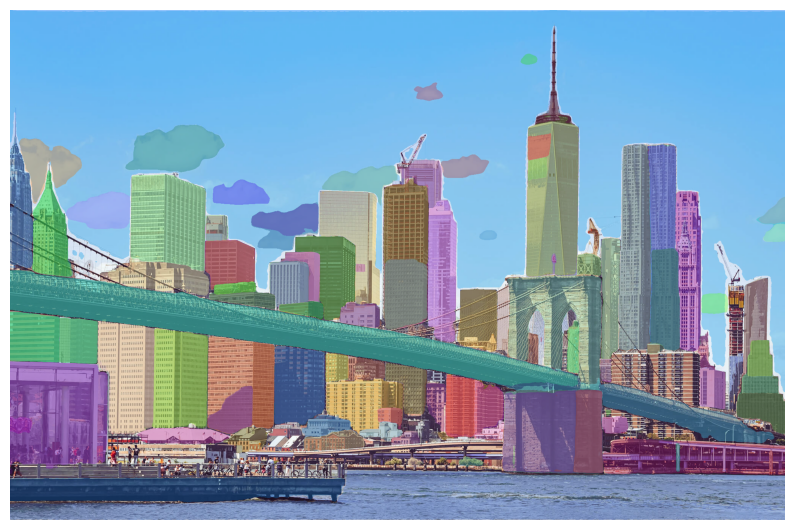

In [4]:
masks = mask_generator.generate(image)
print(f"len(mask)={len(masks)}") # 产生的掩码数量
print(masks[0].keys()) # 第1个掩码内的相关属性

plt.figure(figsize=(10,10))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.show() 


## 调整相关参数

In [5]:
# 配置相关参数
mask_generator_2 = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=32,
    pred_iou_thresh=0.86, # IOU阈值
    stability_score_thresh=0.92, # 稳定性得分阈值
    crop_n_layers=1, 
    crop_n_points_downscale_factor=2,
    min_mask_region_area=100,  # Requires open-cv to run post-processing
)

masks2 = mask_generator_2.generate(image)
print(f"len(mask)={len(masks2)}") # 产生的掩码数量
print(masks2[0].keys())

len(mask)=200
dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


## 可视化结果

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(image)
show_anns(masks2)
plt.axis('off')
plt.show() 

## SamAutomaticMaskGenerator()参数详解：

-  model (Sam):用于掩膜预测的SAM模型。
- points_per_side (int or None): 沿着图像一侧采样的点的数量。点的总数是point_per_side**2。如果没有，'point_grids’必须提供明确的点采样。
- points_per_batch (int):设置模型同时运行的点的数量。更高的数字可能会更快，但会使用更多的GPU内存。
- pred_iou_thresh (float): 滤波阈值，在[0,1]中，使用模型的预测掩膜质量。
- stability_score_thresh (float):滤波阈值，在[0,1]中，使用掩码在用于二进制化模型的掩码预测的截止点变化下的稳定性。
- stability_score_offset (float):计算稳定性分数时，对截止点的偏移量。
- box_nms_thresh (float):非最大抑制用于过滤重复掩码的箱体IoU截止点。
- crop_n_layers (int):如果>0，蒙版预测将在图像的裁剪上再次运行。设置运行的层数，其中每层有2**i_layer的图像裁剪数。
- crop_nms_thresh (float):非最大抑制用于过滤不同作物之间的重复掩码的箱体IoU截止值。
crop_overlap_ratio (float):设置作物重叠的程度。在第一个作物层中，作物将以图像长度的这个分数重叠。在第一个裁剪层中，裁剪物将以图像长度的这一比例重叠，以后的裁剪层中，更多的裁剪物将缩小这一重叠。
- crop_n_points_downscale_factor (int):在图层n中每面采样的点数被crop_n_points_downscale_factor**n缩减。
- point_grids (list(np.ndarray) or None):用于取样的明确网格的列表，归一化为[0,1]。列表中的第n个网格被用于第n个作物层。与points_per_side排他。
- min_mask_region_area (int):如果>0，后处理将被应用于移除面积小于min_mask_region_area的遮罩中的不连接区域和孔。需要opencv。
- output_mode (str):掩模的返回形式。可以是’binary_mask’, ‘uncompressed_rle’, 或者’coco_rle’。coco_rle’需要pycocotools。对于大的分辨率，'binary_mask’可能会消耗大量的内存。

## SamAutomaticMaskGenerator()参数默认值：
- model: Sam,
- points_per_side: Optional[int] = 32,
- points_per_batch: int = 64,
- pred_iou_thresh: float = 0.88,
- stability_score_thresh: float = 0.95,
- stability_score_offset: float = 1.0,
- box_nms_thresh: float = 0.7,
- crop_n_layers: int = 0,
- crop_nms_thresh: float = 0.7,
- crop_overlap_ratio: float = 512 / 1500,
- crop_n_points_downscale_factor: int = 1,
- point_grids: Optional[List[np.ndarray]] = None,
- min_mask_region_area: int = 0,
- output_mode: str = “binary_mask”,

*原文链接：https://blog.csdn.net/weixin_44386956/article/details/130262260*